<a href="https://colab.research.google.com/github/jansoe/AICA/blob/main/Word2Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wortvektoren

In [ ]:
#@title 
#@markdown Importieren von Extrafunktionalität (insbesondere Gensim)

import matplotlib.pyplot as plt
import numpy as np
import nltk
import gensim
from pprint import pprint
from sklearn.metrics.pairwise import cosine_similarity

#Die Bibliothek `gensim` ist etwas veraltet und gibt eine Menge Warnungen aus. 
# Wir können diese aber erstmal getrost ignorieren und deren Ausgabe wie folgt verhindern.
import warnings
warnings.filterwarnings('ignore')

Mit dem `gensim.downloader` können wir vortrainierte Wortvektoren herunterladen.

In [ ]:
import gensim.downloader as api
api.info()['models'].keys()

dict_keys(['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis'])

In [ ]:
model = api.load('glove-wiki-gigaword-300')

[=================================================-] 99.9% 375.9/376.1MB downloaded


### Visualisiern von Wortvektoren

In [ ]:
#@title
#@markdown Funktion zum Visualisieren

def plot_vector(v):
    plt.subplots(figsize=(15,1))
    plt.imshow(v.reshape(1,-1), aspect='auto', cmap=plt.cm.Spectral, vmin=-.3, vmax=.3)
    _ = plt.colorbar()
    plt.yticks([])
    plt.xlabel('Dimension')

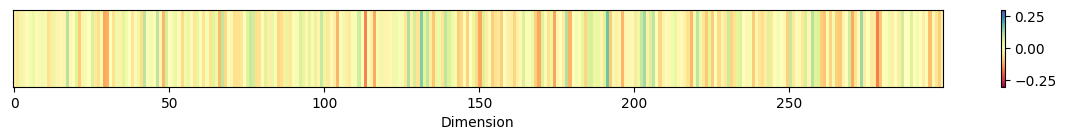

In [ ]:
word_vector1 = model.get_vector('noodles', norm=True)
plot_vector(word_vector1)

## Wortähnlichkeiten

Wir können natürlich auch Wortvektoren vergleichen

Text(0, 0.5, 'pasta-noodles')

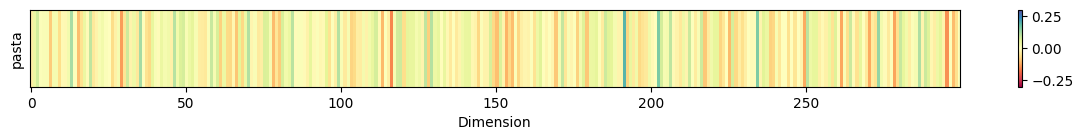

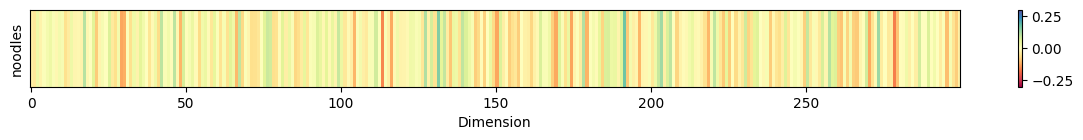

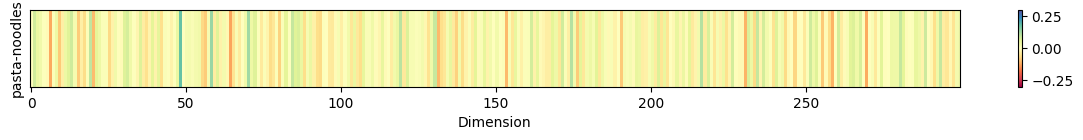

In [ ]:
word1 = 'pasta'
word2 = 'noodles'

word_vector1 = model.get_vector(word1, norm=True)
plot_vector(word_vector1)
plt.ylabel(word1)

word_vector2 = model.get_vector(word2, norm=True)
plot_vector(word_vector2)
plt.ylabel(word2)

difference = word_vector1 - word_vector2 
plot_vector(difference)
plt.ylabel(f'{word1}-{word2}')

Die Ähnlichkeit von 2 Vekoren können wir nicht nur über ihre Differenz sondern auch über den Winkel dazwischen bestimmen:

In [ ]:
cosine_similarity(
    word_vector1.reshape(1, -1), 
    word_vector2.reshape(1, -1)
)

array([[0.63435376]], dtype=float32)

Wir können somit auch  diejenigen Wörter aus dem Korpus heraussuchen, die im latenten Raum am nahesten liegen und somit eine verwandte Bedeutung aufweisen:

In [ ]:
model.most_similar('noodles', topn=5)

[('noodle', 0.6829882264137268),
 ('pasta', 0.634353756904602),
 ('vermicelli', 0.6315168738365173),
 ('tofu', 0.6053614616394043),
 ('cooked', 0.6040924787521362)]

In [ ]:
model.most_similar('shoe', topn=5)

[('shoes', 0.7242045402526855),
 ('footwear', 0.5965994000434875),
 ('sneaker', 0.5847949981689453),
 ('sneakers', 0.5435681343078613),
 ('clothing', 0.5319083333015442)]

### Analogien im Nachbarschaftsraum

Dank der Vektorrepräsentation eines Word2Vec-Modells lässt sich auch leicht nach analogen Verwandtschaftsbeziehungen suchen. Z.B. können wir folgende Aufgabe stellen:

`berlin` verhält sich zu `germany` wie `???` zu `italy`

Die besten Kandidaten für die Lösung dieser Aufgabe können wir heraussuchen, indem wir uns im Vektorraum zu einem entsprechenden Punkt bewegen (`berlin - germany + italy`) und dort die nahesten Begriffe identifizieren: 

In [ ]:
model.most_similar(positive=['berlin', 'italy'], negative=['germany'], topn=1)

[('rome', 0.7019403576850891)]

In [ ]:
model.most_similar(positive=['munich', 'italy'], negative=['germany'], topn=1)

[('milan', 0.6967077255249023)]

In [ ]:
model.most_similar(positive=['beer', 'italy'], negative=['germany'], topn=1)

[('wine', 0.5321523547172546)]

In [ ]:
model.most_similar(positive=['beer', 'russia'], negative=['germany'], topn=1)

[('vodka', 0.5345780849456787)]

### Visualisierung der Wortverwandtschaft mit TSNE
Zuerst visualisieren wir die Verwandtschaftsbeziehungen der Wortvektoren mit TSNE. Dazu lassen wir uns die 200 Wörter heraussuchen, die dem Wort `pasta` am nächsten stehen, und erstellen uns eine Liste von deren Vektoren.

In [ ]:
top_similarity = model.most_similar(positive=['pasta'], topn=200)
selected_words = [word for word, similarity in top_similarity]
vectors = np.array([model.get_vector(word) for word in selected_words])

Jetzt können wir wieder TSNE verwenden, um die hochdimensionalen Vektoren in einem zweidimensionalen Raum zu platzieren und dabei deren lokale Verwandtschaftsbeziehungen beizubehalten.

In [ ]:
import plotly.express as px
import pandas as pd
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components = 2,
    perplexity = 20 # ~Anzahl der Nachbarn zu die der Abstand möglichst genau approximiert werden soll 
)
vectors_2D = tsne.fit_transform(vectors)

to_plot = pd.DataFrame(vectors_2D, columns=['x', 'y'])
to_plot['labels'] = selected_words

px.scatter(to_plot, x='x', y='y', hover_name='labels')

##### Aufgabe: Was beobachten Sie wenn Sie den Parameter Perplexity ändern?

### Visualisierung der Wortverwandtschaften mit PCA

In [ ]:
words_to_vis = [
    'germany', 'italy', 'france', 'spain', 'uk', 'poland', 'russia', 'austria',
    'berlin', 'rome', 'paris', 'madrid', 'london', 'warsaw', 'moscow', 'vienna', 
]

Wir errechnen zunächst wieder die Wortvektoren der ausgewählten Wörter.

In [ ]:
vectors = [model.get_vector(word, norm=True) for word in words_to_vis]

Nun visualisieren wir diese wir in einem 2D-Raum. Anders als zuvor verwenden wir nun jedoch die Methode `PCA`, denn im Gegensatz zu TSNE versucht PCA auch Beziehungen von weit voneinander entfernten Punkten mit abzubilden. Bei wenigen Punkte ist das vorteilhaft, jedoch geht dieser Vorteil bei vielen Punkten schnell verloren, da deren komplexe Nachbarschaftsbeziehungen im hochdimensionalen Raum nicht adäquat in 2D abgebildet werden können.

In [ ]:
from sklearn.decomposition import PCA
import plotly.express as px
import pandas as pd

In [ ]:
pca = PCA(n_components=2)
vectors_2D = pca.fit_transform(vectors)

In [ ]:
to_plot = pd.DataFrame(vectors_2D, columns=['x', 'y'])
to_plot['labels'] = words_to_vis

px.scatter(to_plot, x='x', y='y', hover_name='labels')

#### Aufgabe: Visualierung anderer Begriffe

Ändern sie die Begriffe in der Variable `words_to_vis` und führen Sie alle nachfolgenden Zellen nochmals aus. Sind die visuelle Darstellung der Wordvektoren und ihre Nachbarschaftsbeziehungen intuitiv nachvollziehbar? Können Sie Eigenschaften identifizieren, die im Zusammenhang mit der X- und/oder Y-Achse stehen? 